# SCRAPY

Per cominciare il progetto, iniziamo importando i file csv all'interno di dei dataframe pandas

In [25]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


In [26]:

dataset_path = "./dataset/"

def load_data(dataset_path):
    inputs = pd.read_csv(dataset_path + "inputs.csv", header=None)
    outputs = pd.read_csv(dataset_path + "outputs.csv", header=None)
    mapping = pd.read_csv(dataset_path + "mapping.csv", header=None)
    transactions = pd.read_csv(dataset_path + "transactions.csv", header=None)
    return inputs, outputs, mapping, transactions


print("Loading data...")
inputs, outputs, mapping, transactions = load_data(dataset_path)
print("Done...")

Loading data...
Done...


### Preprocessing
La prima cosa evidente quando leggo questi CSV, è che non è presenti i column name nei file, dunque per comodità, seguendo la traccia li aggiungerò io.

In aggiunta, downscalerò i tipi default (np.int64) alla minore grandezza possibile, così da risparmiare memoria e quindi tempo nelle operazioni.

In [27]:
print("Adding headers to the dataframes...")
# headers transaction
transactions.columns = ["timestamp", "blockId", "txId", "isCoinbase", "fee"]
# headers mapping
mapping.columns = ["addressId", "hash"]
# headers inputs
inputs.columns = ["txId", "prevTxId", "prevTxpos"]
# headers outputs
outputs.columns = ["txId", "position", "addressId", "amount", "scripttype"]
print("Done...")


# In aggiunta, andrò a downcastare ad int16 i campi che posso
# Questo downcast è possibile in quanto i valori presenti nei campi sono tutti numeri interi
# Andrà in automatico al valore minimo possibile per quel campo
print("Downcasting data...")
# Transactions
transactions['timestamp'] = pd.to_numeric(transactions['timestamp'], downcast='integer')
transactions['blockId'] = pd.to_numeric(transactions['blockId'], downcast='integer')
transactions['txId'] = pd.to_numeric(transactions['txId'], downcast='integer')
transactions['fee'] = pd.to_numeric(transactions['fee'], downcast='integer')

# Convert isCoinbase to categorical if it's binary
transactions['isCoinbase'] = transactions['isCoinbase'].astype('category')

# Inputs
inputs['txId'] = pd.to_numeric(inputs['txId'], downcast='integer')
inputs['prevTxId'] = pd.to_numeric(inputs['prevTxId'], downcast='integer')
inputs['prevTxpos'] = pd.to_numeric(inputs['prevTxpos'], downcast='integer')

# Outputs
outputs['txId'] = pd.to_numeric(outputs['txId'], downcast='integer')
outputs['position'] = pd.to_numeric(outputs['position'], downcast='integer')
outputs['addressId'] = pd.to_numeric(outputs['addressId'], downcast='integer')
outputs['amount'] = pd.to_numeric(outputs['amount'], downcast='integer')
outputs['scripttype'] = outputs['scripttype'].astype('category')
print("Done...")

Adding headers to the dataframes...
Done...
Downcasting data...
Done...


### Informazioni dalla traccia
Andiamo a impostare alcune utilities per dopo

In [28]:
# Tutto quanto in bytes
scriptsizes = {
    0: 0,          #Unkown script, size 0...
    1: 153,        #P2PK, Una delle prime versione dello script di pagamento
    2: 180,        #P2PKH, Uno degli script di pagamento più comuni all'epoca
    3: 291         #P2PSH, A P2SH transaction is a transaction whose inputs were locked using a P2SH ScriptPubKey.
}
script_name_map = {
    0: "Unknown",
    1: "P2PK",
    2: "P2PKH",
    3: "P2PSH"
}
avg_input_size = 40     #Dimensione media di un input (da traccia)
avg_output_size = 9     #Dimensione media di un output (da traccia)

## Analisi di dati sulla blockchain
Una delle primissime analisi che ci prendiamo la premura di fare, è quella dell'andamento delle fees rispetto alla congestione della blockchain. Ovvero ci interessa capire se all'aumentare della congestione, aumentano anche le fees. 
La formula che ci restituisce la dimensione in byte di una transazione è la seguente:
$$ size(transaction) = size(input)*\text{n\_inputs} + size(output)* \text{n\_outputs} + size(script)$$
A questo punto la congestione non è altro che la somma delle dimensioni delle transazioni dato un intervallo di tempo. 
L'idea ora è mergiare le transaction, calcolando quanti input ed output ci sono per ognuna e mergiando il risultato del calcolo. A questo punto è importante anche mergiare la script_size corrispettiva (infierendola da uno degli output correlati) e poi calcolare la size della transaction in maniera il più possibile efficiente.
Poi analizzerò il risultato plottando il tutto in un grafico che avrà sotto un barplot con base intervalli di tempo uniformi e altezza dei rettangoli pari alla somma della dimensione delle transazioni nell'intervallo di riferimento, mentre sopra uno scatter che rappresenterà l'andamento del costo medio delle fees negli stessi intervalli di tempo di riferimento sottostanti

In [29]:
RISCRIVERE

# Calcolo del numero di input e output per ogni transazione
input_counts = inputs.groupby('txId').size().reset_index(name='n_inputs')
output_counts = outputs.groupby('txId').size().reset_index(name='n_outputs')

# Unire i conteggi con le transazioni
transactions = transactions.merge(input_counts, on='txId', how='left').fillna(0)
transactions = transactions.merge(output_counts, on='txId', how='left').fillna(0)
# Unisco anche le informazioni sul tipo di script da outputs
transactions = transactions.merge(outputs[['txId', 'scripttype']], on='txId', how='left')
# Calcolo della dimensione dello script utilizzando una mappatura vettoriale
transactions['script_size'] = transactions['scripttype'].map(scriptsizes).astype('int')

print("Computing the size of the transactions...")

print(f"Elaborating a total of {transactions.shape[0]} transactions...")

# Calcolo della dimensione delle transazioni in modo vettoriale
transactions['size'] = (transactions['n_inputs'] * avg_input_size) + \
                       (transactions['n_outputs'] + transactions['script_size']) * \
                       avg_output_size

# Filtro per le sole transazioni che non sono coinbase
non_coinbase_transactions = transactions[transactions['isCoinbase'] == 0]
print("Done calculating the size of the transactions.")


Computing the size of the transactions...
Elaborating a total of 24613803 transactions...
Done calculating the size of the transactions.


Adesso che abbiamo con successo calcolato la size per ogni transazione, possiamo pensare a plottarle come vogliamo per portare avanti l'analisi

/var/folders/94/709l3vzx13966n4stmfhwjqw0000gn/T/ipykernel_65628/3521074891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_coinbase_transactions['date'] = pd.to_datetime(non_coinbase_transactions['timestamp'], unit='s')
/var/folders/94/709l3vzx13966n4stmfhwjqw0000gn/T/ipykernel_65628/3521074891.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(grouped['date'].dt.strftime('%Y-%m-%d'))


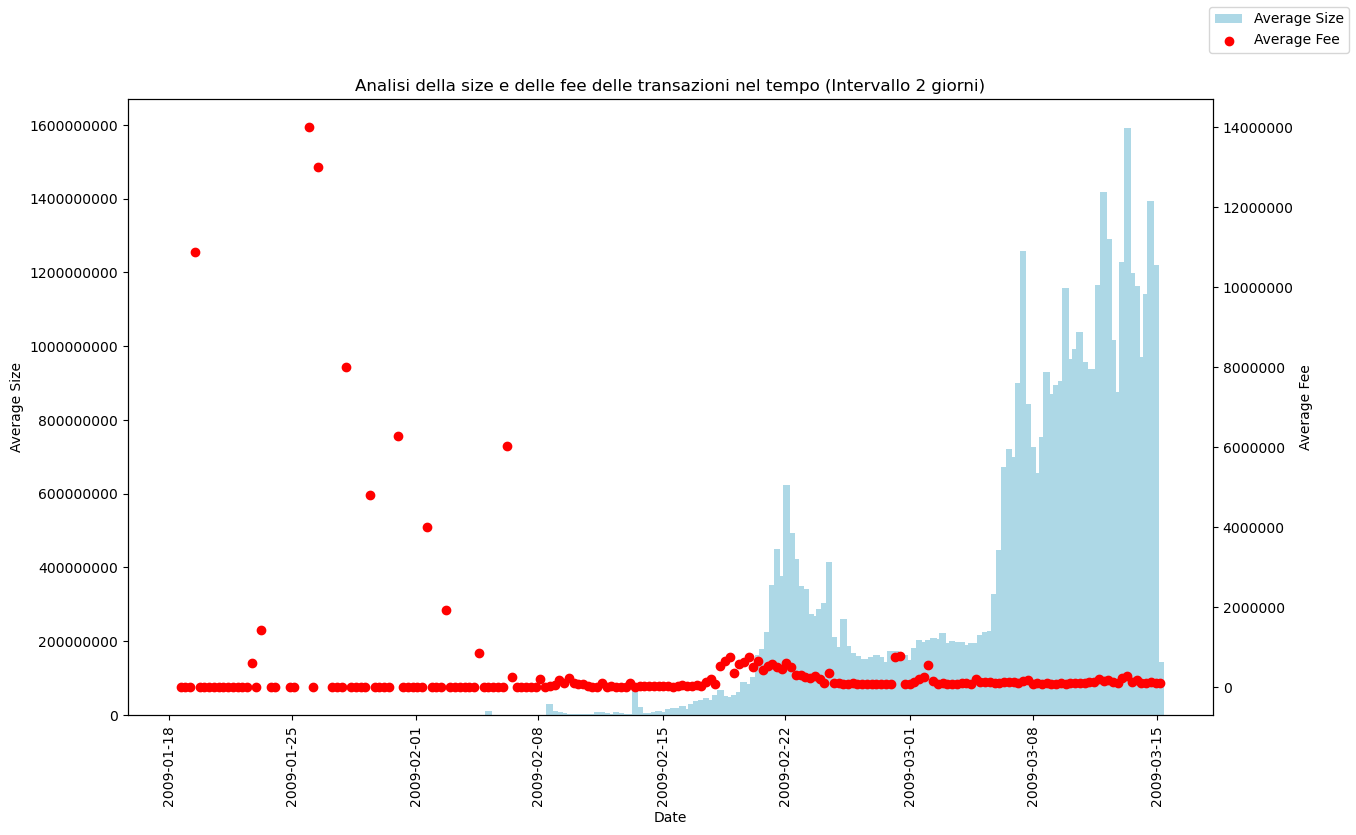

In [30]:
#Serve a rendere il timestamp una data usabile dal grouper
non_coinbase_transactions['date'] = pd.to_datetime(non_coinbase_transactions['timestamp'], unit='s')
# Grouppo per timestamp e calcolo la somma delle transazioni per intervallo e la media delle fees 
# Grouper mi permette di richiedere un raggruppamento temporale con una frequenza di 2 settimane
grouped = non_coinbase_transactions.groupby(pd.Grouper(key='date', freq='W')).agg({
    'size': 'sum',
    'fee': 'mean'
}).reset_index()
# Plot
fig, ax1 = plt.subplots(figsize=(14, 8))

# Questo è il barplot per la size media delle transazioni
ax1.bar(grouped['date'], grouped['size'], width=10, color='lightblue', label='Average Size')
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Size')

# Modifica la rotazione e l'allineamento delle etichette dell'asse x
ax1.tick_params(axis='x', rotation=90)
ax1.set_xticklabels(grouped['date'].dt.strftime('%Y-%m-%d'))
ax1.ticklabel_format(style='plain', axis='y')

# Scatter plot per la fee media che appare dove c'è il barplot della size
ax2 = ax1.twinx()
ax2.scatter(grouped['date'], grouped['fee'], color='red', label='Average Fee')
ax2.set_ylabel('Average Fee')
ax2.ticklabel_format(style='plain', axis='y')

# Combine legends from both axes
fig.legend(loc='upper right')

plt.title('Analisi della size e delle fee delle transazioni nel tempo (Intervallo 2 giorni)')
plt.show()

Quello che vediamo qui è che all'aumentare della congestione, c'è un corrispettivo aumento delle fees in entrata, nonostante la fee media

## Analisi dell'utilizzo dei 3 tipi di script presenti nel dataset nei primi 3 anni

script_name
P2PKH      4832817
P2PK        287174
Unknown         63
P2PSH            0
Name: count, dtype: int64


<Figure size 1400x800 with 0 Axes>

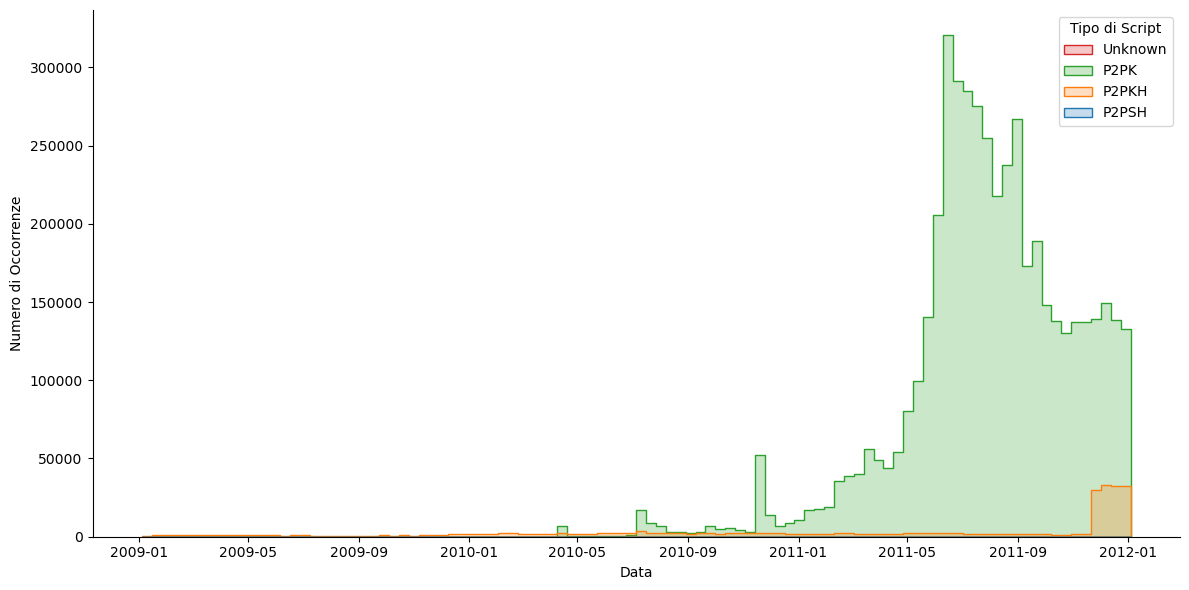

In [35]:
transactions['date'] = pd.to_datetime(transactions['timestamp'], unit='s')

# Filtro come da traccia per solo i primi 3 anni
start = transactions['date'].min()
end = start + pd.DateOffset(years=3)
transactions_first_3_years = transactions[transactions['date'] < end]

transactions_first_3_years = transactions_first_3_years.merge(outputs[['txId', 'scripttype']].drop_duplicates(), on='txId', how='left')
transactions_first_3_years['script_name'] = transactions_first_3_years['scripttype_x'].map(script_name_map)
print(transactions_first_3_years["script_name"].value_counts())
data_grouped = transactions_first_3_years.groupby(['date', 'script_name'], observed=False).size().reset_index(name='count')

plt.figure(figsize=(14, 8))
g = sns.displot(
    data=data_grouped, 
    x='date', 
    hue='script_name', 
    weights='count', 
    kind='hist', 
    bins=100,
    height=6,
    aspect=2,
    element='step',
    legend=False

)

g.set_axis_labels('Data', 'Numero di Occorrenze')
g.set_titles('Distribuzione nel Tempo di scripttype')
plt.legend(title='Tipo di Script', labels=['Unknown', 'P2PK', 'P2PKH', 'P2PSH'])
plt.show()
# uso un displot per fare un istogramma della distribuzione dello script usato


Quello che notiamo dal grafico sopra, è che nel primo anno della blockchain, l'unico script utilizzato era P2PK (inoltre notiamo che il quantitativo di transazioni è ben minore rispetto agli anni successivi).
Nei 2 anni successivi è entrato in utilizzo quasi esclusivamente P2PKH.
Questo ci suggerisce che la stra grande maggioranza degli utenti sulla blockchain ha preferito P2PKH rispetto a P2PK.
L'analisi ci torna coerente poiché P2PKH risulta più sicuro, esponendo l'hash della chiave pubblica piuttosto che la chiave pubblica stessa come avviene in P2PK.

Non ci sono occorrenze per P2PSH, il che ci suggerisce che per vederlo utilizzato dobbiamo espandere la finestra di riferimento, probabilmente oltre il 2012. 

Una cosa che purtroppo non si osserva da questa particolare vista, è che sono presenti 63 transazioni con scripttype Unknown, un numero fin troppo piccolo per risultare visibile in comparazioni con le altre 2 tipologie dominanti.

Ricordiamoci che le occorrenze di P2PSH e Unknown in questo dataset rimangono estremamente basse. (336 occorrenze totali di P2PSH e 5906 occorrenze di Unknown)



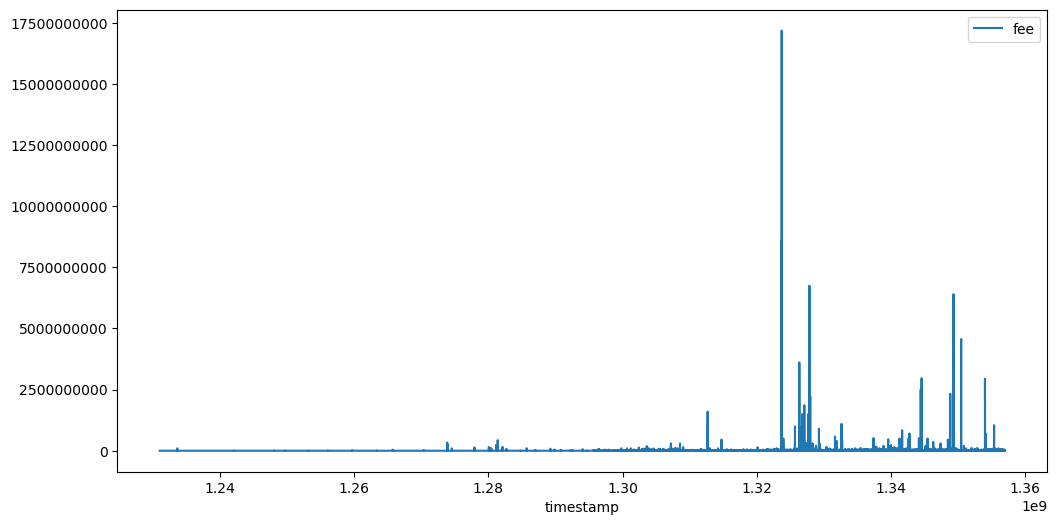

In [32]:
transactions.plot(x='timestamp', y='fee', kind='line', figsize=(12, 6))
plt.ticklabel_format(style='plain', axis='y')
plt.show()             